### יבוא ספריות 

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import os
import glob
import zipfile
import json
from wordcloud import WordCloud

### 

In [97]:
download_steam_data = False

if download_steam_data:
  	# Step 1: Install Kaggle package
	!pip install kaggle
	api_token = {"username":"avigailshekasta1","key":"0d13b10e9e14df1f7f5be441689822f9"}
	os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
	with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as file:
		json.dump(api_token, file)

	os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)
	# Step 4: Download the dataset
	!kaggle datasets download tamber/steam-video-games -p ./datasets

In [98]:
if download_steam_data:
	# Path to the datasets folder
	dataset_path = './datasets/'

	# Get a list of all zip files in the datasets folder
	zip_files = glob.glob(os.path.join(dataset_path, '*.zip'))

	for zip_file in zip_files:
		# Get the name of the unzipped folder by removing the .zip extension
		unzipped_folder = zip_file.replace('.zip', '')

		# Check if the unzipped folder already exists
		if not os.path.exists(unzipped_folder):
			# If the folder doesn't exist, unzip the file
			with zipfile.ZipFile(zip_file, 'r') as zip_ref:
				zip_ref.extractall(dataset_path)
			print(f'Unzipped: {zip_file}')
		else:
			print(f'Skipping, already unzipped: {unzipped_folder}')


In [99]:
steam = pd.read_csv("./datasets/steam-200k.csv", header = None, names=["Player_ID", "Game_title", "Behavior", "Hours", "Ignore"])
steam.head(10)

,Player_ID,Game_title,Behavior,Hours,Ignore
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0
5,151603712,Spore,play,14.9,0
6,151603712,Fallout New Vegas,purchase,1.0,0
7,151603712,Fallout New Vegas,play,12.1,0
8,151603712,Left 4 Dead 2,purchase,1.0,0
9,151603712,Left 4 Dead 2,play,8.9,0


### preprocessing - עיבוד מקדים

In [100]:
steam = steam.drop(columns=['Ignore'])

In [101]:
steam.groupby(['Game_title','Player_ID','Behavior'])['Hours'].count().reset_index().sort_values('Hours')

,Game_title,Player_ID,Behavior,Hours
0,007 Legends,46055854,play,1
132622,Quake Live,2259650,purchase,1
132623,Quake Live,2753525,play,1
132624,Quake Live,2753525,purchase,1
132625,Quake Live,7955670,purchase,1
...,...,...,...,...
84899,Grand Theft Auto San Andreas,26762388,purchase,2
85132,Grand Theft Auto San Andreas,172434236,purchase,2
85131,Grand Theft Auto San Andreas,170947678,purchase,2
85153,Grand Theft Auto San Andreas,216688763,purchase,2


###### ניתן לראות שיש שורות שחוזרות על עצמן כאשר מודבר על אותו שחקן, אותו משחק ואותו התנהגות. 

In [102]:
steam = steam.groupby(['Game_title','Player_ID','Behavior'])['Hours'].sum().reset_index().sort_values('Hours')

### data description - תיאור המאגר

In [103]:
print(f"data shape: {steam.shape}")

data shape: (199281, 4)


In [104]:
steam.describe()

,Player_ID,Hours
count,1.992810e+05,199281.000000
mean,1.037194e+08,17.938874
std,7.212121e+07,138.301650
min,5.250000e+03,0.100000
25%,4.738430e+07,1.000000
50%,8.691201e+07,1.000000
75%,1.542309e+08,1.400000
max,3.099031e+08,11754.000000


In [105]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199281 entries, 179129 to 148143
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Game_title  199281 non-null  object 
 1   Player_ID   199281 non-null  int64  
 2   Behavior    199281 non-null  object 
 3   Hours       199281 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 7.6+ MB


In [106]:
print(f"Number of unique players: {steam.Player_ID.nunique():,}")
print(f"Number of unique games: {steam.Game_title.nunique():,}")

Number of unique players: 12,393
Number of unique games: 5,155


#### purchases

In [107]:
sum_of_purchases = steam[steam.Behavior == 'purchase'].groupby('Player_ID').sum()
sum_of_purchases["Hours"].sort_values(ascending=False)

Player_ID
62990992     1075.0
33865373      783.0
30246419      766.0
58345543      667.0
76892907      597.0
              ...  
169958335       1.0
169953184       1.0
169919297       1.0
169845810       1.0
309903146       1.0
Name: Hours, Length: 12393, dtype: float64

In [108]:
print(f"Average hours spent on purchases: {sum_of_purchases['Hours'].mean():.2f}")

Average hours spent on purchases: 10.45


In [109]:
steamPurchase = steam[steam.Behavior == 'purchase']
Purchasing = steamPurchase.Game_title.value_counts()
dfPurchase = pd.DataFrame(Purchasing).reset_index()
dfPurchase.columns = ['Game_title', 'Number_of_times_purchased']
dfPurchase.head(10)

,Game_title,Number_of_times_purchased
0,Dota 2,4841
1,Team Fortress 2,2323
2,Unturned,1563
3,Counter-Strike Global Offensive,1412
4,Half-Life 2 Lost Coast,981
5,Counter-Strike Source,978
6,Left 4 Dead 2,951
7,Counter-Strike,856
8,Warframe,847
9,Half-Life 2 Deathmatch,823


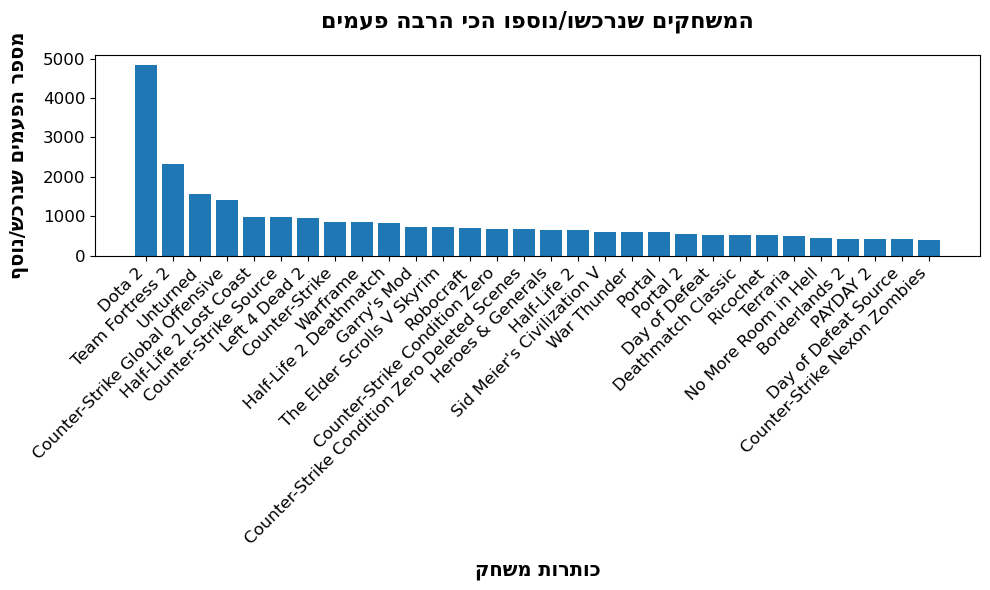

In [110]:
# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(dfPurchase[:30]['Game_title'], dfPurchase[:30]['Number_of_times_purchased'])
ax.set_title("המשחקים שנרכשו/נוספו הכי הרבה פעמים"[::-1], fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("כותרות משחק"[::-1], fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel("מספר הפעמים שנרכש/נוסף"[::-1], fontsize=14, fontweight='bold', labelpad=10)
ax.tick_params(axis='x', labelrotation=45, labelsize=12, colors='black')
ax.tick_params(axis='y', labelsize=12, colors='black')
plt.xticks(rotation=45, ha='right')
# Show the plot
plt.tight_layout()
plt.show()

#### play

In [111]:
steamPlay = steam[steam.Behavior == 'play']
steamPlay.shape

(70477, 4)

In [112]:
print(f"Number of unique players who have played: {steamPlay.Player_ID.nunique():,}")

Number of unique players who have played: 11,350


In [113]:
Game_by_Hour = steamPlay.groupby('Game_title')['Hours'].sum()
sorted_by_hour = Game_by_Hour.sort_values(ascending = False)
sorted_by_hour[:10]

Game_title
Dota 2                                         981684.6
Counter-Strike Global Offensive                322771.6
Team Fortress 2                                173673.3
Counter-Strike                                 134261.1
Sid Meier's Civilization V                      99821.3
Counter-Strike Source                           96075.5
The Elder Scrolls V Skyrim                      70889.3
Garry's Mod                                     49725.3
Call of Duty Modern Warfare 2 - Multiplayer     42009.9
Left 4 Dead 2                                   33596.7
Name: Hours, dtype: float64

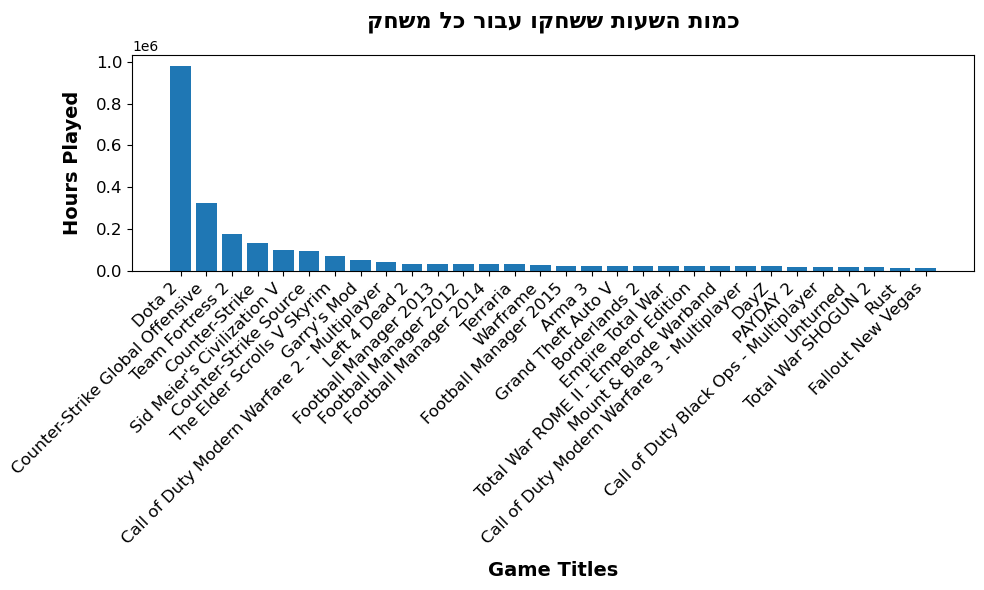

In [114]:
Game_by_Hour_df = pd.DataFrame(sorted_by_hour).reset_index()
Game_by_Hour_df.columns = ['Game_title', 'Hours']
Game_by_Hour_df = Game_by_Hour_df[:30]
# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(Game_by_Hour_df['Game_title'], Game_by_Hour_df['Hours'])

# Customize the plot
ax.set_title("כמות השעות ששחקו עבור כל משחק"[::-1], fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Game Titles", fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel("Hours Played", fontsize=14, fontweight='bold', labelpad=10)
ax.tick_params(axis='x', labelrotation=45, labelsize=12, colors='black')
ax.tick_params(axis='y', labelsize=12, colors='black')

plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


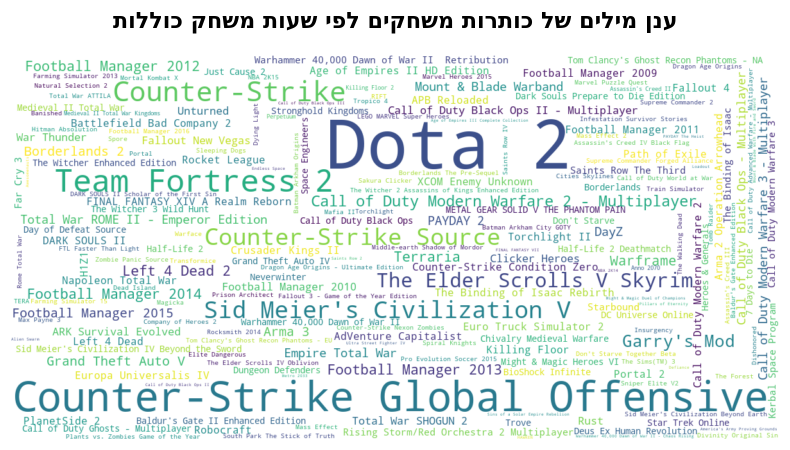

In [115]:
# Group by 'Game_title' and sum the 'Hours'
game_hours = steamPlay.groupby('Game_title')['Hours'].sum()

# Convert the Series to a dictionary for the word cloud
game_hours_dict = game_hours.to_dict()

# Create the word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(game_hours_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Game Titles by Total Hours Played")
# hebrew title
plt.title("ענן מילים של כותרות משחקים לפי שעות משחק כוללות"[::-1], fontsize=16, fontweight='bold', pad=20)
plt.show()

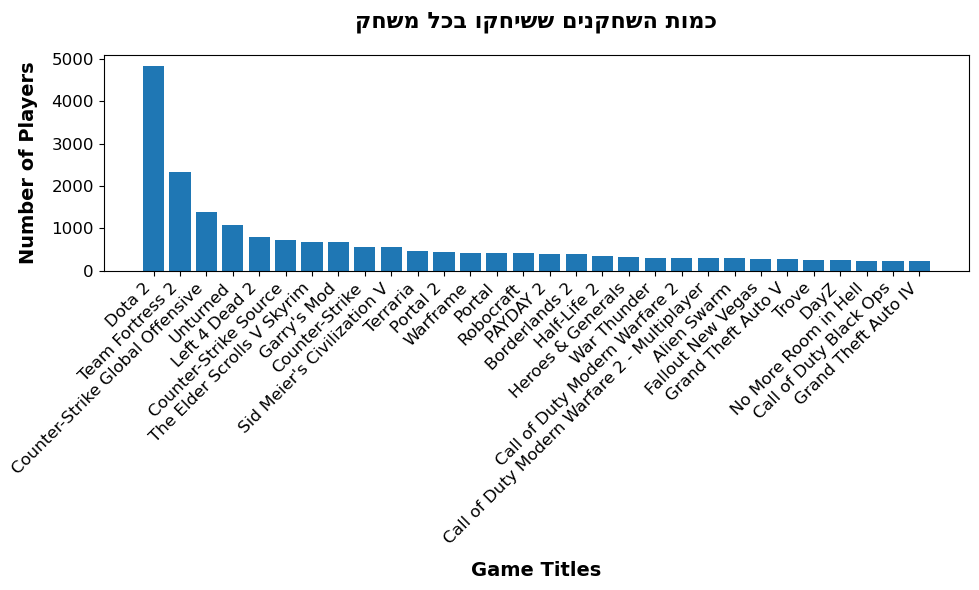

In [116]:
for_each_game_how_many_players_has_played_with = steamPlay.groupby('Game_title')['Player_ID'].count().sort_values(ascending = False)
# plot graph
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(for_each_game_how_many_players_has_played_with.index[:30], for_each_game_how_many_players_has_played_with[:30])

# Customize the plot
ax.set_title("כמות השחקנים ששיחקו בכל משחק"[::-1], fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Game Titles", fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel("Number of Players", fontsize=14, fontweight='bold', labelpad=10)
ax.tick_params(axis='x', labelrotation=45, labelsize=12, colors='black')
ax.tick_params(axis='y', labelsize=12, colors='black')

plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()

plt.show()

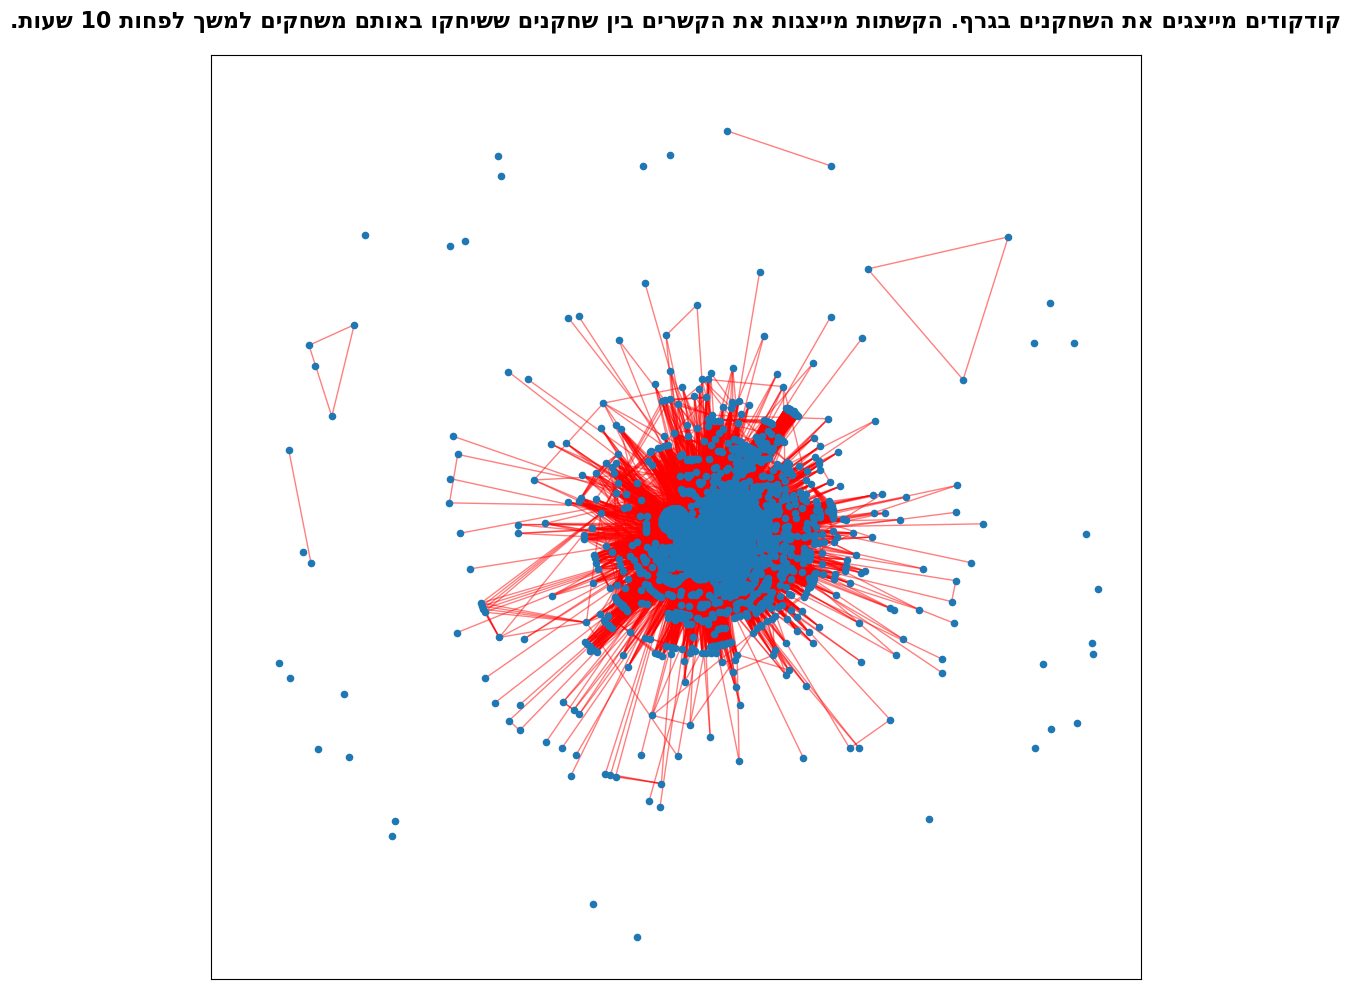

In [117]:
filtered_data = steamPlay[steamPlay['Hours'] >= 10]

# Create a bipartite graph
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
players = filtered_data['Player_ID'].unique()
games = filtered_data['Game_title'].unique()

B.add_nodes_from(players, bipartite=0)  # Add the player nodes
B.add_nodes_from(games, bipartite=1)  # Add the game nodes

# Add edges between players and games they played for at least 5 hours
for _, row in filtered_data.iterrows():
    B.add_edge(row['Player_ID'], row['Game_title'])
    
player_graph = nx.bipartite.weighted_projected_graph(B, players)

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(player_graph, k=0.1)  # Positions for all nodes

# Draw nodes and edges
nx.draw_networkx_nodes(player_graph, pos, node_size=20)
nx.draw_networkx_edges(player_graph, pos, width=1.0, alpha=0.5, edge_color='r')

plt.title("קודקודים מייצגים את השחקנים בגרף. הקשתות מייצגות את הקשרים בין שחקנים ששיחקו באותם משחקים למשך לפחות 01 שעות."[::-1], fontsize=16, fontweight='bold', pad=20)
plt.show()
